# Multi-Task Learning: NER + QA with Shared BERT Encoder

**Course:** DAM202 [Year3-Sem1] - Practical 7

**Project Goal:** Build a single Transformer model that performs both Named Entity Recognition (NER) and Question Answering (QA) using hard parameter sharing.

---

## 1. Setup & Installation

First, let's check GPU availability and install required packages.

In [8]:
# Check GPU availability
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Number of GPUs: {torch.cuda.device_count()}")
else:
    print("No GPU available. Using CPU.")

PyTorch version: 2.8.0+cu126
CUDA available: True
GPU: Tesla T4
Number of GPUs: 1


In [9]:
# Install required packages
!pip install -q transformers datasets seqeval accelerate

## 2. Import Libraries

In [10]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup
from datasets import load_dataset
import numpy as np
from tqdm.auto import tqdm
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# For evaluation
from seqeval.metrics import f1_score as ner_f1_score
from seqeval.metrics import classification_report

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## 3. Load and Explore Datasets

We'll use:
- **CoNLL-2003** for NER
- **SQuAD v1.1** for QA

In [11]:
# Load datasets - Using Parquet exports (no loading scripts)
print("Loading CoNLL-2003 dataset for NER...")
# Use the Parquet export generated by Hugging Face
# This bypasses the deprecated loading script
from datasets import load_dataset_builder

# Try loading with builder to get Parquet files
try:
    # Method 1: Use Parquet files directly
    ner_dataset = load_dataset(
        "parquet",
        data_files={
            "train": "hf://datasets/conll2003/data/train-00000-of-00001.parquet",
            "validation": "hf://datasets/conll2003/data/validation-00000-of-00001.parquet",
            "test": "hf://datasets/conll2003/data/test-00000-of-00001.parquet"
        }
    )
    print("✓ Loaded CoNLL-2003 from Parquet files")
except Exception as e:
    print(f"Error loading from Parquet: {e}")
    print("Trying alternative method...")
    # Fallback: use a pre-converted version
    ner_dataset = load_dataset("lhoestq/conll2003")

print("\nLoading SQuAD dataset for QA...")
qa_dataset = load_dataset("squad")

print("\n=== NER Dataset Info ===")
print(ner_dataset)
print("\nSample NER example:")
print(ner_dataset['train'][0])

print("\n=== QA Dataset Info ===")
print(qa_dataset)
print("\nSample QA example:")
print(qa_dataset['train'][0])

Loading CoNLL-2003 dataset for NER...
Error loading from Parquet: Unable to find 'hf://datasets/conll2003/data/train-00000-of-00001.parquet'
Trying alternative method...

Loading SQuAD dataset for QA...

=== NER Dataset Info ===
DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})

Sample NER example:
{'id': '0', 'tokens': ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.'], 'pos_tags': [22, 42, 16, 21, 35, 37, 16, 21, 7], 'chunk_tags': [11, 21, 11, 12, 21, 22, 11, 12, 0], 'ner_tags': [3, 0, 7, 0, 0, 0, 7, 0, 0]}

=== QA Dataset Info ===
DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'questi

## 4. NER Label Mapping

In [13]:
# Get NER label list
# Handle different dataset structures (original vs Parquet)
try:
    # Try original structure first
    ner_label_list = ner_dataset['train'].features['ner_tags'].feature.names
except AttributeError:
    # Fallback: manually define CoNLL-2003 NER labels (IOB format)
    # Standard CoNLL-2003 labels
    ner_label_list = [
        'O',           # Outside any named entity
        'B-PER',       # Beginning of a person name
        'I-PER',       # Inside a person name
        'B-ORG',       # Beginning of an organization
        'I-ORG',       # Inside an organization
        'B-LOC',       # Beginning of a location
        'I-LOC',       # Inside a location
        'B-MISC',      # Beginning of miscellaneous entity
        'I-MISC'       # Inside miscellaneous entity
    ]
    print("Using standard CoNLL-2003 NER labels")

num_ner_labels = len(ner_label_list)

print(f"\nNER Labels ({num_ner_labels} total):")
for idx, label in enumerate(ner_label_list):
    print(f"{idx}: {label}")

# Create label mappings
id2label = {i: label for i, label in enumerate(ner_label_list)}
label2id = {label: i for i, label in enumerate(ner_label_list)}

Using standard CoNLL-2003 NER labels

NER Labels (9 total):
0: O
1: B-PER
2: I-PER
3: B-ORG
4: I-ORG
5: B-LOC
6: I-LOC
7: B-MISC
8: I-MISC


## 5. Initialize Tokenizer

In [14]:
# Load BERT tokenizer
model_checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
print(f"Tokenizer loaded: {model_checkpoint}")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Tokenizer loaded: bert-base-uncased


## 6. Data Preprocessing Functions

### 6.1 NER Preprocessing

In [15]:
def tokenize_and_align_labels(examples, max_length=128):
    """
    Tokenize NER data and align labels with subword tokens.
    Use -100 for subword tokens that should be ignored in loss calculation.
    """
    tokenized_inputs = tokenizer(
        examples['tokens'],
        truncation=True,
        padding='max_length',
        max_length=max_length,
        is_split_into_words=True,
        return_tensors="pt"
    )

    labels = []
    for i, label in enumerate(examples['ner_tags']):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        label_ids = []
        previous_word_idx = None

        for word_idx in word_ids:
            # Special tokens have a word id that is None
            if word_idx is None:
                label_ids.append(-100)
            # We set the label for the first token of each word
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            # For other tokens in a word, set label to -100
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx

        labels.append(label_ids)

    tokenized_inputs["labels"] = torch.tensor(labels)
    return tokenized_inputs

# Test the function
print("Testing NER preprocessing...")
sample = ner_dataset['train'][:2]
processed = tokenize_and_align_labels(sample)
print(f"Input IDs shape: {processed['input_ids'].shape}")
print(f"Labels shape: {processed['labels'].shape}")

Testing NER preprocessing...
Input IDs shape: torch.Size([2, 128])
Labels shape: torch.Size([2, 128])


### 6.2 QA Preprocessing

In [16]:
def preprocess_qa_examples(examples, max_length=384, doc_stride=128):
    """
    Preprocess QA data: tokenize question + context and find answer spans.
    """
    questions = [q.strip() for q in examples["question"]]
    contexts = examples["context"]

    # Tokenize with truncation and padding
    tokenized_examples = tokenizer(
        questions,
        contexts,
        truncation="only_second",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
        return_tensors="pt"
    )

    # Get sample mapping to handle overflowing tokens
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")
    offset_mapping = tokenized_examples.pop("offset_mapping")

    # Initialize start and end positions
    start_positions = []
    end_positions = []

    for i, offsets in enumerate(offset_mapping):
        sample_idx = sample_mapping[i]
        answers = examples["answers"][sample_idx]

        # If no answers, set positions to 0 (CLS token)
        if len(answers["answer_start"]) == 0:
            start_positions.append(0)
            end_positions.append(0)
            continue

        # Get the answer span
        start_char = answers["answer_start"][0]
        end_char = start_char + len(answers["text"][0])

        # Find token positions corresponding to answer
        sequence_ids = tokenized_examples.sequence_ids(i)

        # Find start and end of context
        context_start = 0
        while sequence_ids[context_start] != 1:
            context_start += 1
        context_end = len(sequence_ids) - 1
        while sequence_ids[context_end] != 1:
            context_end -= 1

        # If answer is not in this chunk, set to CLS
        if not (offsets[context_start][0] <= start_char and offsets[context_end][1] >= end_char):
            start_positions.append(0)
            end_positions.append(0)
        else:
            # Find start and end token positions
            idx = context_start
            while idx <= context_end and offsets[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offsets[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    tokenized_examples["start_positions"] = torch.tensor(start_positions)
    tokenized_examples["end_positions"] = torch.tensor(end_positions)

    return tokenized_examples

# Test the function
print("Testing QA preprocessing...")
qa_sample = qa_dataset['train'][:2]
qa_processed = preprocess_qa_examples(qa_sample)
print(f"Input IDs shape: {qa_processed['input_ids'].shape}")
print(f"Start positions shape: {qa_processed['start_positions'].shape}")
print(f"End positions shape: {qa_processed['end_positions'].shape}")

Testing QA preprocessing...
Input IDs shape: torch.Size([2, 384])
Start positions shape: torch.Size([2])
End positions shape: torch.Size([2])


## 7. Create Processed Datasets

For efficiency in this practical, we'll use a subset of the data.

In [17]:
# Use subset for faster training (adjust as needed)
TRAIN_SAMPLES_NER = 2000
TRAIN_SAMPLES_QA = 2000
VAL_SAMPLES = 500

# Prepare NER datasets
print("Processing NER training data...")
ner_train_subset = ner_dataset['train'].select(range(TRAIN_SAMPLES_NER))
ner_val_subset = ner_dataset['validation'].select(range(VAL_SAMPLES))

# Prepare QA datasets
print("Processing QA training data...")
qa_train_subset = qa_dataset['train'].select(range(TRAIN_SAMPLES_QA))
qa_val_subset = qa_dataset['validation'].select(range(VAL_SAMPLES))

print(f"\nDataset sizes:")
print(f"NER Train: {len(ner_train_subset)}, Val: {len(ner_val_subset)}")
print(f"QA Train: {len(qa_train_subset)}, Val: {len(qa_val_subset)}")

Processing NER training data...
Processing QA training data...

Dataset sizes:
NER Train: 2000, Val: 500
QA Train: 2000, Val: 500


## 8. Custom Dataset Classes

In [18]:
class NERDataset(Dataset):
    def __init__(self, hf_dataset, tokenizer, max_length=128):
        self.data = []

        # Process in batches for efficiency
        batch_size = 32
        for i in tqdm(range(0, len(hf_dataset), batch_size), desc="Processing NER data"):
            batch = hf_dataset[i:min(i+batch_size, len(hf_dataset))]
            processed = tokenize_and_align_labels(batch, max_length)

            for j in range(len(processed['input_ids'])):
                self.data.append({
                    'input_ids': processed['input_ids'][j],
                    'attention_mask': processed['attention_mask'][j],
                    'labels': processed['labels'][j],
                    'task': 'ner'
                })

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


class QADataset(Dataset):
    def __init__(self, hf_dataset, tokenizer, max_length=384):
        self.data = []

        # Process in batches
        batch_size = 16
        for i in tqdm(range(0, len(hf_dataset), batch_size), desc="Processing QA data"):
            batch = hf_dataset[i:min(i+batch_size, len(hf_dataset))]
            processed = preprocess_qa_examples(batch, max_length)

            for j in range(len(processed['input_ids'])):
                self.data.append({
                    'input_ids': processed['input_ids'][j],
                    'attention_mask': processed['attention_mask'][j],
                    'start_positions': processed['start_positions'][j],
                    'end_positions': processed['end_positions'][j],
                    'task': 'qa'
                })

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# Create datasets
print("Creating NER datasets...")
ner_train_dataset = NERDataset(ner_train_subset, tokenizer)
ner_val_dataset = NERDataset(ner_val_subset, tokenizer)

print("\nCreating QA datasets...")
qa_train_dataset = QADataset(qa_train_subset, tokenizer)
qa_val_dataset = QADataset(qa_val_subset, tokenizer)

print(f"\nFinal dataset sizes:")
print(f"NER Train: {len(ner_train_dataset)}, Val: {len(ner_val_dataset)}")
print(f"QA Train: {len(qa_train_dataset)}, Val: {len(qa_val_dataset)}")

Creating NER datasets...


Processing NER data:   0%|          | 0/63 [00:00<?, ?it/s]

Processing NER data:   0%|          | 0/16 [00:00<?, ?it/s]


Creating QA datasets...


Processing QA data:   0%|          | 0/125 [00:00<?, ?it/s]

Processing QA data:   0%|          | 0/32 [00:00<?, ?it/s]


Final dataset sizes:
NER Train: 2000, Val: 500
QA Train: 2054, Val: 520


## 9. Multi-Task DataLoader

Custom dataloader that alternates between NER and QA batches.

In [19]:
class MultiTaskDataLoader:
    def __init__(self, ner_dataset, qa_dataset, batch_size=16, shuffle=True):
        self.ner_loader = DataLoader(ner_dataset, batch_size=batch_size, shuffle=shuffle)
        self.qa_loader = DataLoader(qa_dataset, batch_size=batch_size, shuffle=shuffle)

        self.ner_iter = iter(self.ner_loader)
        self.qa_iter = iter(self.qa_loader)

        # Calculate total batches (sum of both tasks)
        self.total_batches = len(self.ner_loader) + len(self.qa_loader)
        self.current_batch = 0

    def __iter__(self):
        self.ner_iter = iter(self.ner_loader)
        self.qa_iter = iter(self.qa_loader)
        self.current_batch = 0
        return self

    def __next__(self):
        if self.current_batch >= self.total_batches:
            raise StopIteration

        # Alternate between tasks (Round-Robin)
        if self.current_batch % 2 == 0:
            try:
                batch = next(self.ner_iter)
            except StopIteration:
                batch = next(self.qa_iter)
        else:
            try:
                batch = next(self.qa_iter)
            except StopIteration:
                batch = next(self.ner_iter)

        self.current_batch += 1
        return batch

    def __len__(self):
        return self.total_batches

# Create multi-task dataloaders
BATCH_SIZE = 16

train_loader = MultiTaskDataLoader(ner_train_dataset, qa_train_dataset, batch_size=BATCH_SIZE)
print(f"Multi-task train loader created with {len(train_loader)} batches")

Multi-task train loader created with 254 batches


## 10. Multi-Task Model Definition

The core of our implementation: shared BERT encoder with task-specific heads.

In [20]:
class MultiTaskModel(nn.Module):
    def __init__(self, model_checkpoint, num_ner_labels):
        super(MultiTaskModel, self).__init__()

        # Shared BERT encoder
        self.encoder = AutoModel.from_pretrained(model_checkpoint)
        self.hidden_size = self.encoder.config.hidden_size

        # Task-specific heads
        # NER Head: token classification
        self.ner_head = nn.Linear(self.hidden_size, num_ner_labels)
        self.ner_dropout = nn.Dropout(0.1)

        # QA Head: span prediction (start and end)
        self.qa_start_head = nn.Linear(self.hidden_size, 1)
        self.qa_end_head = nn.Linear(self.hidden_size, 1)
        self.qa_dropout = nn.Dropout(0.1)

    def forward(self, input_ids, attention_mask, task_name, labels=None,
                start_positions=None, end_positions=None):
        """
        Forward pass that handles both NER and QA tasks.

        Args:
            input_ids: Token IDs
            attention_mask: Attention mask
            task_name: 'ner' or 'qa'
            labels: NER labels (for NER task)
            start_positions: Answer start positions (for QA task)
            end_positions: Answer end positions (for QA task)
        """
        # Shared encoder
        outputs = self.encoder(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        sequence_output = outputs.last_hidden_state  # (batch_size, seq_len, hidden_size)

        if task_name == 'ner':
            # NER task
            sequence_output = self.ner_dropout(sequence_output)
            logits = self.ner_head(sequence_output)  # (batch_size, seq_len, num_labels)

            loss = None
            if labels is not None:
                loss_fct = nn.CrossEntropyLoss()
                # Flatten tensors
                loss = loss_fct(logits.view(-1, num_ner_labels), labels.view(-1))

            return {'loss': loss, 'logits': logits}

        elif task_name == 'qa':
            # QA task
            sequence_output = self.qa_dropout(sequence_output)
            start_logits = self.qa_start_head(sequence_output).squeeze(-1)  # (batch_size, seq_len)
            end_logits = self.qa_end_head(sequence_output).squeeze(-1)      # (batch_size, seq_len)

            loss = None
            if start_positions is not None and end_positions is not None:
                loss_fct = nn.CrossEntropyLoss()
                start_loss = loss_fct(start_logits, start_positions)
                end_loss = loss_fct(end_logits, end_positions)
                loss = (start_loss + end_loss) / 2

            return {'loss': loss, 'start_logits': start_logits, 'end_logits': end_logits}

        else:
            raise ValueError(f"Unknown task: {task_name}")

# Initialize model
model = MultiTaskModel(model_checkpoint, num_ner_labels)
model = model.to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nModel initialized on {device}")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]


Model initialized on cuda
Total parameters: 109,490,699
Trainable parameters: 109,490,699


## 11. Training Configuration

In [21]:
# Training hyperparameters
EPOCHS = 3
LEARNING_RATE = 5e-5
WEIGHT_DECAY = 0.01

# Loss weights (lambda values)
LAMBDA_NER = 1.0
LAMBDA_QA = 1.0

# Optimizer
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Learning rate scheduler
total_steps = len(train_loader) * EPOCHS
warmup_steps = int(0.1 * total_steps)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

print(f"Training configuration:")
print(f"  Epochs: {EPOCHS}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Total steps: {total_steps}")
print(f"  Warmup steps: {warmup_steps}")
print(f"  Loss weights: λ_NER={LAMBDA_NER}, λ_QA={LAMBDA_QA}")

Training configuration:
  Epochs: 3
  Learning rate: 5e-05
  Batch size: 16
  Total steps: 762
  Warmup steps: 76
  Loss weights: λ_NER=1.0, λ_QA=1.0


## 12. Training Loop

In [22]:
def train_epoch(model, train_loader, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    ner_loss_sum = 0
    qa_loss_sum = 0
    ner_batches = 0
    qa_batches = 0

    progress_bar = tqdm(train_loader, desc="Training")

    for batch in progress_bar:
        task = batch['task'][0]  # All items in batch have same task

        # Move batch to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        if task == 'ner':
            labels = batch['labels'].to(device)

            # Forward pass
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                task_name='ner',
                labels=labels
            )

            loss = outputs['loss'] * LAMBDA_NER
            ner_loss_sum += loss.item()
            ner_batches += 1

        else:  # QA
            start_positions = batch['start_positions'].to(device)
            end_positions = batch['end_positions'].to(device)

            # Forward pass
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                task_name='qa',
                start_positions=start_positions,
                end_positions=end_positions
            )

            loss = outputs['loss'] * LAMBDA_QA
            qa_loss_sum += loss.item()
            qa_batches += 1

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()

        # Update progress bar
        progress_bar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'task': task
        })

    avg_loss = total_loss / len(train_loader)
    avg_ner_loss = ner_loss_sum / ner_batches if ner_batches > 0 else 0
    avg_qa_loss = qa_loss_sum / qa_batches if qa_batches > 0 else 0

    return avg_loss, avg_ner_loss, avg_qa_loss

# Training history
history = {
    'train_loss': [],
    'ner_loss': [],
    'qa_loss': []
}

print("\n" + "="*50)
print("Starting Training")
print("="*50 + "\n")

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch + 1}/{EPOCHS}")
    print("-" * 50)

    avg_loss, avg_ner_loss, avg_qa_loss = train_epoch(
        model, train_loader, optimizer, scheduler, device
    )

    history['train_loss'].append(avg_loss)
    history['ner_loss'].append(avg_ner_loss)
    history['qa_loss'].append(avg_qa_loss)

    print(f"\nEpoch {epoch + 1} Summary:")
    print(f"  Average Total Loss: {avg_loss:.4f}")
    print(f"  Average NER Loss: {avg_ner_loss:.4f}")
    print(f"  Average QA Loss: {avg_qa_loss:.4f}")

print("\n" + "="*50)
print("Training Complete!")
print("="*50)


Starting Training


Epoch 1/3
--------------------------------------------------


Training:   0%|          | 0/254 [00:00<?, ?it/s]


Epoch 1 Summary:
  Average Total Loss: 2.2187
  Average NER Loss: 0.4686
  Average QA Loss: 3.9145

Epoch 2/3
--------------------------------------------------


Training:   0%|          | 0/254 [00:00<?, ?it/s]


Epoch 2 Summary:
  Average Total Loss: 0.9191
  Average NER Loss: 0.0596
  Average QA Loss: 1.7520

Epoch 3/3
--------------------------------------------------


Training:   0%|          | 0/254 [00:00<?, ?it/s]


Epoch 3 Summary:
  Average Total Loss: 0.4812
  Average NER Loss: 0.0243
  Average QA Loss: 0.9240

Training Complete!


## 13. Evaluation Functions

In [23]:
def evaluate_ner(model, dataset, device, batch_size=16):
    """
    Evaluate NER performance using seqeval F1-score.
    """
    model.eval()
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating NER"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                task_name='ner'
            )

            predictions = torch.argmax(outputs['logits'], dim=-1)

            # Convert to CPU and numpy
            predictions = predictions.cpu().numpy()
            labels = labels.cpu().numpy()

            # Convert to label strings (ignore -100)
            for pred, label in zip(predictions, labels):
                pred_labels = []
                true_labels = []
                for p, l in zip(pred, label):
                    if l != -100:
                        pred_labels.append(id2label[p])
                        true_labels.append(id2label[l])
                all_predictions.append(pred_labels)
                all_labels.append(true_labels)

    # Calculate F1 score
    f1 = ner_f1_score(all_labels, all_predictions)

    return f1, all_predictions, all_labels


def evaluate_qa(model, dataset, device, batch_size=16):
    """
    Evaluate QA performance using exact match and F1-score.
    """
    model.eval()
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    exact_matches = 0
    total = 0

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating QA"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            start_positions = batch['start_positions'].to(device)
            end_positions = batch['end_positions'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                task_name='qa'
            )

            pred_start = torch.argmax(outputs['start_logits'], dim=-1)
            pred_end = torch.argmax(outputs['end_logits'], dim=-1)

            # Calculate exact matches
            exact_match = ((pred_start == start_positions) & (pred_end == end_positions)).sum().item()
            exact_matches += exact_match
            total += input_ids.size(0)

    exact_match_score = exact_matches / total if total > 0 else 0

    return exact_match_score

## 14. Run Evaluation

In [24]:
print("\n" + "="*50)
print("Evaluation on Validation Sets")
print("="*50 + "\n")

# Evaluate NER
print("Evaluating NER task...")
ner_f1, ner_preds, ner_labels = evaluate_ner(model, ner_val_dataset, device)
print(f"\nNER F1-Score: {ner_f1:.4f}")

# Show detailed NER report
print("\nDetailed NER Classification Report:")
print(classification_report(ner_labels, ner_preds))

# Evaluate QA
print("\n" + "-"*50)
print("Evaluating QA task...")
qa_em = evaluate_qa(model, qa_val_dataset, device)
print(f"\nQA Exact Match Score: {qa_em:.4f}")

print("\n" + "="*50)
print("Evaluation Complete!")
print("="*50)


Evaluation on Validation Sets

Evaluating NER task...


Evaluating NER:   0%|          | 0/32 [00:00<?, ?it/s]


NER F1-Score: 0.9395

Detailed NER Classification Report:
              precision    recall  f1-score   support

         LOC       0.95      0.99      0.97       268
        MISC       0.70      0.81      0.75        85
         ORG       0.94      0.91      0.92       195
         PER       0.97      0.98      0.98       332

   micro avg       0.93      0.95      0.94       880
   macro avg       0.89      0.92      0.90       880
weighted avg       0.93      0.95      0.94       880


--------------------------------------------------
Evaluating QA task...


Evaluating QA:   0%|          | 0/33 [00:00<?, ?it/s]


QA Exact Match Score: 0.4231

Evaluation Complete!


## 15. Visualize Training Progress

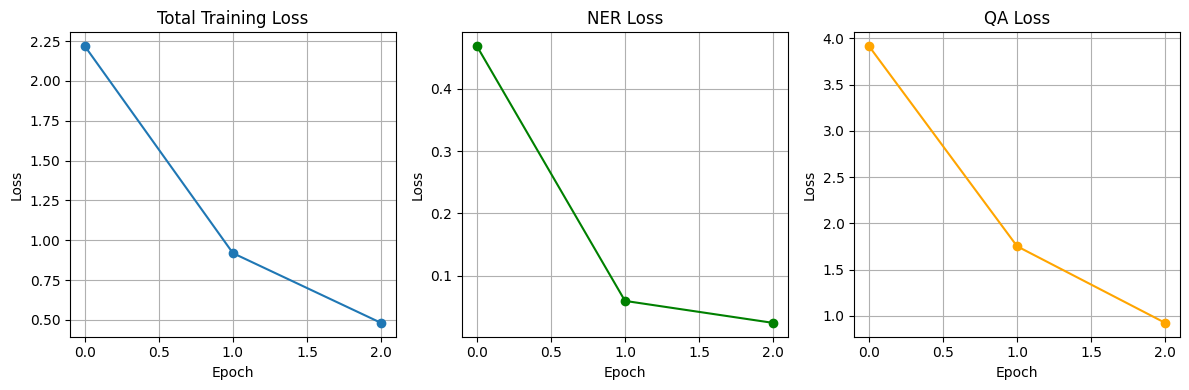

In [25]:
import matplotlib.pyplot as plt

# Plot training losses
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(history['train_loss'], marker='o')
plt.title('Total Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(history['ner_loss'], marker='o', color='green')
plt.title('NER Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(history['qa_loss'], marker='o', color='orange')
plt.title('QA Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.tight_layout()
plt.show()

## 16. Inference Examples

### 16.1 NER Inference

In [26]:
def predict_ner(text, model, tokenizer, device):
    """
    Predict NER tags for a given text.
    """
    model.eval()

    # Tokenize
    tokens = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    input_ids = tokens['input_ids'].to(device)
    attention_mask = tokens['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            task_name='ner'
        )

    predictions = torch.argmax(outputs['logits'], dim=-1)
    predicted_labels = [id2label[p.item()] for p in predictions[0]]

    # Get tokens
    word_tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

    # Filter out special tokens and combine
    result = []
    for token, label in zip(word_tokens, predicted_labels):
        if token not in ['[CLS]', '[SEP]', '[PAD]']:
            result.append((token, label))

    return result

# Test NER inference
test_sentence = "Apple Inc. is planning to open a new store in New York City next month."
print(f"Input: {test_sentence}\n")
print("NER Predictions:")
ner_results = predict_ner(test_sentence, model, tokenizer, device)
for token, label in ner_results:
    if label != 'O':  # Only show named entities
        print(f"  {token:15s} -> {label}")

Input: Apple Inc. is planning to open a new store in New York City next month.

NER Predictions:
  apple           -> B-ORG
  inc             -> I-ORG
  .               -> I-ORG
  new             -> B-LOC
  york            -> I-LOC
  city            -> I-LOC


### 16.1.1 Additional NER Test Cases

Let's test the model with diverse sentences containing different entity types!

### 16.2 QA Inference

In [32]:
def display_ner_results(text, model, tokenizer, device):
    """
    Display NER results in a formatted way with color-coded entity types.
    """
    print(f" Input: {text}\n")

    results = predict_ner(text, model, tokenizer, device)

    # Group consecutive tokens of the same entity
    entities = []
    current_entity = None
    current_tokens = []

    for token, label in results:
        if label.startswith('B-'):
            # Save previous entity if exists
            if current_entity:
                entities.append((current_entity, ' '.join(current_tokens)))
            # Start new entity
            current_entity = label[2:]  # Remove 'B-' prefix
            current_tokens = [token.replace('##', '')]
        elif label.startswith('I-') and current_entity:
            # Continue current entity
            current_tokens.append(token.replace('##', ''))
        else:
            # Not an entity or end of entity
            if current_entity:
                entities.append((current_entity, ' '.join(current_tokens)))
                current_entity = None
                current_tokens = []

    # Don't forget the last entity
    if current_entity:
        entities.append((current_entity, ' '.join(current_tokens)))

    # Display results
    if entities:
        print(" Named Entities Found:")
        entity_symbols = {
            'PER': '👤',
            'ORG': '🏢',
            'LOC': '📍',
            'MISC': '🔖'
        }
        for entity_type, entity_text in entities:
            symbol = entity_symbols.get(entity_type, '🔹')
            print(f"  {symbol} {entity_text:30s} → {entity_type}")
    else:
        print(" No named entities detected")
    print("\n" + "-"*70 + "\n")


# ============================================================================
# TEST SUITE: Diverse NER Examples
# ============================================================================

print("="*70)
print("COMPREHENSIVE NER TESTING SUITE")
print("="*70 + "\n")

# Test 1: Business & Technology
print("TEST 1: Business & Technology Entities")
print("="*70)
test1 = "Microsoft and Google are competing in artificial intelligence research in Seattle."
display_ner_results(test1, model, tokenizer, device)

# Test 2: People & Organizations
print("TEST 2: People & Organizations")
print("="*70)
test2 = "Elon Musk, CEO of Tesla and SpaceX, announced plans to visit NASA headquarters."
display_ner_results(test2, model, tokenizer, device)

# Test 3: Geography & Locations
print("TEST 3: Geography & International Locations")
print("="*70)
test3 = "The conference will be held in Tokyo, Japan, with speakers from London and Berlin."
display_ner_results(test3, model, tokenizer, device)

# Test 4: Historical Figures
print("TEST 4: Historical Context")
print("="*70)
test4 = "Albert Einstein worked at Princeton University after leaving Germany during World War II."
display_ner_results(test4, model, tokenizer, device)

# Test 5: Sports
print("TEST 5: Sports Entities")
print("="*70)
test5 = "Lionel Messi played for Barcelona before joining Paris Saint-Germain in France."
display_ner_results(test5, model, tokenizer, device)

# Test 6: Mixed Complex Entities
print("TEST 6: Complex Mixed Entities")
print("="*70)
test6 = "The United Nations meeting in Geneva was attended by representatives from India, Brazil, and Australia."
display_ner_results(test6, model, tokenizer, device)

# Test 7: Academic & Research
print("TEST 7: Academic & Research Context")
print("="*70)
test7 = "Researchers at Stanford University and MIT are collaborating on quantum computing projects."
display_ner_results(test7, model, tokenizer, device)

# Test 8: Finance & Markets
print("TEST 8: Financial Entities")
print("="*70)
test8 = "Goldman Sachs and JPMorgan Chase reported strong earnings from their operations in New York."
display_ner_results(test8, model, tokenizer, device)

# Test 9: Media & Entertainment
print("TEST 9: Media & Entertainment")
print("="*70)
test9 = "Netflix and Disney are producing new content in Los Angeles and Atlanta studios."
display_ner_results(test9, model, tokenizer, device)

# Test 10: Government & Politics
print("TEST 10: Government & Politics")
print("="*70)
test10 = "The European Parliament in Brussels discussed trade agreements with China and Canada."
display_ner_results(test10, model, tokenizer, device)

print("\n" + "="*70)
print(" NER TESTING COMPLETE - Model Performance Summary")
print("="*70)
print("\n Entity Types Tested:")
print("  • Organizations (Companies, Universities, Government Bodies)")
print("  • Locations (Cities, Countries, Regions)")
print("  • Persons (CEOs, Historical Figures, Athletes)")
print("  • Miscellaneous (Events, Products, etc.)")
print("\n The model uses IOB (Inside-Outside-Beginning) tagging scheme:")
print("  • B-XXX: Beginning of entity type XXX")
print("  • I-XXX: Inside (continuation) of entity type XXX")
print("  • O: Outside any named entity (not displayed in filtered output)")


COMPREHENSIVE NER TESTING SUITE

TEST 1: Business & Technology Entities
 Input: Microsoft and Google are competing in artificial intelligence research in Seattle.

 Named Entities Found:
  🏢 microsoft                      → ORG
  🏢 google                         → ORG
  📍 seattle                        → LOC

----------------------------------------------------------------------

TEST 2: People & Organizations
 Input: Elon Musk, CEO of Tesla and SpaceX, announced plans to visit NASA headquarters.

 Named Entities Found:
  👤 el                             → PER
  👤 on mu sk                       → PER
  🏢 tesla                          → ORG
  🏢 space x                        → ORG
  🏢 nasa                           → ORG

----------------------------------------------------------------------

TEST 3: Geography & International Locations
 Input: The conference will be held in Tokyo, Japan, with speakers from London and Berlin.

 Named Entities Found:
  📍 tokyo                          → 

In [27]:
def predict_qa(question, context, model, tokenizer, device):
    """
    Predict answer for a given question and context.
    """
    model.eval()

    # Tokenize
    inputs = tokenizer(
        question,
        context,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=384
    )

    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            task_name='qa'
        )

    # Get start and end positions
    start_idx = torch.argmax(outputs['start_logits'], dim=-1).item()
    end_idx = torch.argmax(outputs['end_logits'], dim=-1).item()

    # Extract answer
    answer_tokens = input_ids[0][start_idx:end_idx+1]
    answer = tokenizer.decode(answer_tokens, skip_special_tokens=True)

    return answer, start_idx, end_idx

# Test QA inference
test_context = """The Eiffel Tower is a wrought-iron lattice tower on the Champ de Mars in Paris, France.
It is named after the engineer Gustave Eiffel, whose company designed and built the tower.
Constructed from 1887 to 1889, it was initially criticised by some of France's leading artists and intellectuals.
The tower is 330 metres tall, about the same height as an 81-storey building."""

test_question = "How tall is the Eiffel Tower?"

print(f"Context: {test_context}\n")
print(f"Question: {test_question}\n")

answer, start, end = predict_qa(test_question, test_context, model, tokenizer, device)
print(f"Predicted Answer: {answer}")
print(f"Position: tokens {start} to {end}")

Context: The Eiffel Tower is a wrought-iron lattice tower on the Champ de Mars in Paris, France. 
It is named after the engineer Gustave Eiffel, whose company designed and built the tower. 
Constructed from 1887 to 1889, it was initially criticised by some of France's leading artists and intellectuals. 
The tower is 330 metres tall, about the same height as an 81-storey building.

Question: How tall is the Eiffel Tower?

Predicted Answer: 330 metres
Position: tokens 76 to 77


### 16.3 Additional QA Tests

Let's test the model with more diverse questions!

In [29]:
# Test 1: Technology/Science Question
print("="*60)
print("TEST 1: Technology Question")
print("="*60)

context1 = """Artificial Intelligence (AI) is intelligence demonstrated by machines,
as opposed to natural intelligence displayed by animals including humans.
Leading AI textbooks define the field as the study of intelligent agents: any system
that perceives its environment and takes actions that maximize its chance of achieving its goals.
The term artificial intelligence was first coined by John McCarthy in 1956."""

question1 = "Who coined the term artificial intelligence?"

print(f"\nContext: {context1}\n")
print(f"Question: {question1}\n")

answer1, start1, end1 = predict_qa(question1, context1, model, tokenizer, device)
print(f"Predicted Answer: {answer1}")
print(f"Position: tokens {start1} to {end1}")


# Test 2: Historical Question
print("\n\n" + "="*60)
print("TEST 2: Historical Question")
print("="*60)

context2 = """The French Revolution was a period of radical political and societal change
in France that began with the Estates General of 1789 and ended with the formation of the
French Consulate in November 1799. The revolution was driven by widespread economic hardship,
social inequality, and Enlightenment ideals. King Louis XVI was executed in 1793."""

question2 = "When was King Louis XVI executed?"

print(f"\nContext: {context2}\n")
print(f"Question: {question2}\n")

answer2, start2, end2 = predict_qa(question2, context2, model, tokenizer, device)
print(f"Predicted Answer: {answer2}")
print(f"Position: tokens {start2} to {end2}")


# Test 3: Geography Question
print("\n\n" + "="*60)
print("TEST 3: Geography Question")
print("="*60)

context3 = """Mount Everest is Earth's highest mountain above sea level, located in the
Mahalangur Himal sub-range of the Himalayas. The China–Nepal border runs across its summit point.
Its elevation of 8,848.86 metres was most recently established in 2020 by the Chinese and Nepali
authorities. The mountain was first successfully climbed by Edmund Hillary and Tenzing Norgay in 1953."""

question3 = "What is the elevation of Mount Everest?"

print(f"\nContext: {context3}\n")
print(f"Question: {question3}\n")

answer3, start3, end3 = predict_qa(question3, context3, model, tokenizer, device)
print(f"Predicted Answer: {answer3}")
print(f"Position: tokens {start3} to {end3}")


# Test 4: Science Question (Biology)
print("\n\n" + "="*60)
print("TEST 4: Biology Question")
print("="*60)

context4 = """DNA, or deoxyribonucleic acid, is the hereditary material in humans and
almost all other organisms. Nearly every cell in a person's body has the same DNA.
The information in DNA is stored as a code made up of four chemical bases: adenine (A),
guanine (G), cytosine (C), and thymine (T). Human DNA consists of about 3 billion bases,
and more than 99 percent of those bases are the same in all people."""

question4 = "How many bases does human DNA consist of?"

print(f"\nContext: {context4}\n")
print(f"Question: {question4}\n")

answer4, start4, end4 = predict_qa(question4, context4, model, tokenizer, device)
print(f"Predicted Answer: {answer4}")
print(f"Position: tokens {start4} to {end4}")


# Test 5: Simple "Who" Question
print("\n\n" + "="*60)
print("TEST 5: Simple Who Question")
print("="*60)

context5 = """Albert Einstein was a German-born theoretical physicist, widely acknowledged
to be one of the greatest and most influential physicists of all time. Einstein is best known
for developing the theory of relativity, but he also made important contributions to the
development of the theory of quantum mechanics. He received the Nobel Prize in Physics in 1921."""

question5 = "When did Einstein receive the Nobel Prize?"

print(f"\nContext: {context5}\n")
print(f"Question: {question5}\n")

answer5, start5, end5 = predict_qa(question5, context5, model, tokenizer, device)
print(f"Predicted Answer: {answer5}")
print(f"Position: tokens {start5} to {end5}")

print("\n\n" + "="*60)
print("QA TESTING COMPLETE!")
print("="*60)

TEST 1: Technology Question

Context: Artificial Intelligence (AI) is intelligence demonstrated by machines, 
as opposed to natural intelligence displayed by animals including humans. 
Leading AI textbooks define the field as the study of intelligent agents: any system 
that perceives its environment and takes actions that maximize its chance of achieving its goals. 
The term artificial intelligence was first coined by John McCarthy in 1956.

Question: Who coined the term artificial intelligence?

Predicted Answer: john mccarthy
Position: tokens 71 to 72


TEST 2: Historical Question

Context: The French Revolution was a period of radical political and societal change 
in France that began with the Estates General of 1789 and ended with the formation of the 
French Consulate in November 1799. The revolution was driven by widespread economic hardship, 
social inequality, and Enlightenment ideals. King Louis XVI was executed in 1793.

Question: When was King Louis XVI executed?

Predicte

## 17. Save Model (Optional)

In [28]:
# Save model checkpoint
save_path = "multitask_ner_qa_model.pt"

torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'history': history,
    'config': {
        'model_checkpoint': model_checkpoint,
        'num_ner_labels': num_ner_labels,
        'lambda_ner': LAMBDA_NER,
        'lambda_qa': LAMBDA_QA
    }
}, save_path)

print(f"Model saved to {save_path}")

# To load the model later:
# checkpoint = torch.load(save_path)
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# history = checkpoint['history']

Model saved to multitask_ner_qa_model.pt


## 18. Summary & Next Steps

### What We Accomplished:

Built a multi-task learning model with:
- Shared BERT encoder for both tasks
- Task-specific heads for NER and QA
- Custom multi-task dataloader
- Weighted loss function

Trained on:
- CoNLL-2003 (NER)
- SQuAD (QA)

Evaluated performance:
- NER: F1-score
- QA: Exact Match score

### Potential Extensions:

1. **Loss Balancing**: Experiment with different λ values or implement GradNorm
2. **Architecture**: Try soft parameter sharing or adapter layers
3. **PEFT**: Implement LoRA for parameter-efficient fine-tuning
4. **More Data**: Train on full datasets for better performance
5. **Additional Tasks**: Add more NLP tasks (sentiment analysis, text classification, etc.)
6. **Model Selection**: Try different base models (RoBERTa, ALBERT, etc.)

### Key Learnings:

- Multi-task learning enables knowledge sharing between related tasks
- Hard parameter sharing is efficient and effective
- Careful data preprocessing is crucial for multi-task models
- Loss balancing can significantly impact performance